In [1]:
__author__ = "Sumedha Biswas"

import sys
from astropy.io import ascii
import os
import numpy as np
import pandas as pd
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy import time, coordinates as coord, units as u
from astropy.coordinates import search_around_sky
import matplotlib.pyplot as plt 
from astropy.table import unique, Table, vstack
import healpy as hp
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from astropy.table import unique

In [106]:
# # Reading in the GW skymap regions (50% probability regions, 512 healpixels)

# # S190728q
# e1 = pd.read_csv('s190728q_50prob_512.csv')
# e1coord = coord.SkyCoord(e1['ra'], e1['dec'], unit=(u.deg,u.deg), frame='icrs')

# #S200129m
# e2 = pd.read_csv('s200129m_50prob_512.csv')
# e2coord = coord.SkyCoord(e2['ra'], e2['dec'], unit=(u.deg,u.deg), frame='icrs')

# combined = pd.concat([e1, e2], axis=0)
# combined = Table.from_pandas(combined)

# combined

In [ ]:
# Reading in the GW combined catalog 

gw = pd.read_csv('combined_gw.csv')


In [108]:
# Reading in the GLADE+ catalog (optimized version)

glade = pd.read_csv('GLADE+.txt')

# Modifying the table

glade = glade['GLADE_num   HyperLEDA_name     RA Dec                           '].str.split(' ', expand=True)
glade.drop(glade.iloc[:, 10:39], inplace=True, axis=1)
glade.drop(glade.columns[[1, 2, 4, 5, 6, 7]], axis=1, inplace=True)
glade.drop([39], axis=1)
glade.rename(columns = {0:'GLADE_num', 3:'HyperLEDA_name', 8:'RA', 9:'Dec'}, inplace = True)
glade.drop([39], axis=1)

glade.drop(glade.index[-1])

,GLADE_num,HyperLEDA_name,RA,Dec,39
0,1,NGC4736,192.721451,41.120152,
1,2,NGC4548,188.860123,14.49632,
2,3,NGC6503,267.360474,70.144341,
3,4,NGC4442,187.01622,9.80362,
4,5,NGC4469,187.367,8.74989,
...,...,...,...,...,...
23181753,23181754,null,359.999118,28.954734000000002,
23181754,23181755,null,359.999303,34.720842,
23181755,23181756,null,359.999615,3.268586,
23181756,23181757,null,359.999759,20.721079,


In [78]:
# df = pd.DataFrame({'RA':[glade['RA']], 'Dec':[glade['Dec']]})
# # df.RA
# # gladecoord = coord.SkyCoord(df.RA, df.Dec, unit=(u.deg,u.deg), frame='icrs')
# # print(gladecoord)

# df = pd.concat(
#     (df, SkyCoord(df.RA, df.Dec, frame='icrs', unit=(u.deg,u.deg)).to_table().to_pandas()),
#     axis=0).rename(columns={'ra': 'RAJ2000', 'dec': 'DEJ2000'})
glade

,GLADE_num,HyperLEDA_name,RA,Dec,39
0,1,NGC4736,192.721451,41.120152,
1,2,NGC4548,188.860123,14.49632,
2,3,NGC6503,267.360474,70.144341,
3,4,NGC4442,187.01622,9.80362,
4,5,NGC4469,187.367,8.74989,
...,...,...,...,...,...
23181754,23181755,null,359.999303,34.720842,
23181755,23181756,null,359.999615,3.268586,
23181756,23181757,null,359.999759,20.721079,
23181757,23181758,null,359.999954,34.747133000000005,


In [109]:
glade.drop(glade.index[-1])

# glade = Table.from_pandas(glade)
glade_ = Table()
glade_['GLADE_num'] = glade.GLADE_num
glade_['HyperLEDA_name'] = glade.HyperLEDA_name
glade_['RA'] = glade.RA
glade_['Dec'] = glade.Dec
glade_.remove_row(23181758)

glade_['RA'] = glade_['RA'].astype(float)
glade_['Dec'] = glade_['Dec'].astype(float)
glade_

GLADE_num,HyperLEDA_name,RA,Dec
object,object,float64,float64
1,NGC4736,192.721451,41.120152
2,NGC4548,188.860123,14.49632
3,NGC6503,267.360474,70.144341
4,NGC4442,187.01622,9.80362
5,NGC4469,187.367,8.74989
6,NGC4586,189.618484,4.319099
7,NGC4440,186.973221,12.293191
8,NGC4387,186.423813,12.810359
9,NGC4424,186.799,9.42031


In [110]:
# S190728q: raMean < 322 and raMean > 310 and decMean < 18.5 and decMean > 4
e1_gp = Table(glade_[0:0])
for i in range(0, len(glade_)):
    if glade_['RA'][i] < 322 and glade_['RA'][i] > 310 and glade_['Dec'][i] < 18.5 and glade_['Dec'][i] > 4:
        e1_gp.add_row(glade_[i]) 
        # print(e1_gp)
        
# S200129m: raMean < 320 and raMean > 316 and decMean < 9 and decMean > 1.2
e2_gp = Table(glade_[0:0])
for i in range(0, len(glade_)):
    if glade_['RA'][i] < 320 and glade_['RA'][i] > 316 and glade_['Dec'][i] < 9 and glade_['Dec'][i] > 1.2:
        e2_gp.add_row(glade_[i]) 

In [113]:
e1_gp.write("s190728q_gp.csv", format="csv", overwrite=True)
e2_gp.write("s200129m_gp.csv", format="csv", overwrite=True)

In [92]:
def makeHealpixMap(ra, dec, nside=512, nest=True):
    # convert a ra/dec catalog into healpix map with counts per cell
    ipix = hp.ang2pix(nside, (90-dec)/180*np.pi, ra/180*np.pi, nest=nest)
    return np.bincount(ipix, minlength=hp.nside2npix(nside)) 


# theta = np.deg2rad(glade_['RA'])
# phi = np.deg2rad(glade_['Dec'])
# gladecoord = SkyCoord(glade_['RA'], glade_['Dec'], unit='deg', representation_type='cartesian')

# pix = hp.ang2pix(512, theta, phi, nest='True')



# glade_pix = Table()
# glade_pix = glade_
for i in range(0, len(glade_)):
    glade_['pix'][i] = hp.ang2pix(512, glade_['RA'][i]*u.rad, glade_['Dec'][i]*u.rad)

ValueError: THETA is out of range [0,pi]

In [88]:
pix

array([ 8,  9, 17, ...,  7, 10,  8])

In [44]:
hp = HEALPix(nside=512,order='nested',frame=ICRS())
hpid = hp.skycoord_to_healpix(gladecoord)

ValueError: Invalid character at col 0 in angle 'RA'

In [ ]:
# Matching the healpixel IDs of the GW coordinates and the GLADE+ catalog 



e1_gp = join(e1, glade, key_left = 'hp', key_right = 'hpid')
e1_gp = join(e2, glade, key_left = 'hp', key_right = 'hpid')

In [76]:
# Cross-matching GW source with GLADE+, in a radius of 1 arcmin

# S190728q, results in 313 galaxies
idx1, idx2, sep2d, dist3d = search_around_sky(gladecoord, e1coord, 1*u.arcmin)
match1 = glade[idx1]
ascii.write(match1, 'glade_p_s190728q.csv', overwrite=True)

# S200129m, results in 650 galaxies
idx1, idx2, sep2d, dist3d = search_around_sky(gladecoord, e2coord, 1*u.arcmin)
match2 = glade[idx1]
ascii.write(match2, 'glade_p_s200129m.csv', overwrite=True)

In [29]:
# Reading in the GLADE+ matched files (temp. solution to deal with system error)

e1_gp = ascii.read('glade_p_s190728q.csv')
e2_gp = ascii.read('glade_p_s200129m.csv')

In [31]:
# Cross-matching GW source with PS1 DR1, in a radius of 1 arcmin
# Using MAST API (https://catalogs.mast.stsci.edu/panstarrs/)
# Max. cross-match radius is 3 arcsec

# S190728q
e1_ps = ascii.read('s190728q_ps1dr1_1arcsec.csv', delimiter=',', guess=False, fast_reader=False)

# S200129m
e2_ps = ascii.read('s200129m_ps1dr1_1arcsec.csv', delimiter=',', guess=False, fast_reader=False)

In [25]:
# e1_ps = unique(e2_ps, 'objID') # 787458
# e2_ps = unique(e2_ps, 'objID') # 400097

In [61]:
# Combining GLADE+ and PS1 DR2 sources

# S190728q 

e1_gp_ps = vstack([e1_gp, e1_ps])

# S200129m 

e2_gp_ps = vstack([e2_gp, e2_ps])

In [66]:
# Combining the GW sources 

e1e2_gp_ps = vstack([e1_gp_ps, e2_gp_ps])

ascii.write(e1e2_gp_ps, 's190728q_s200129m_gp_ps.csv')

In [65]:
# e1e2_gp_ps

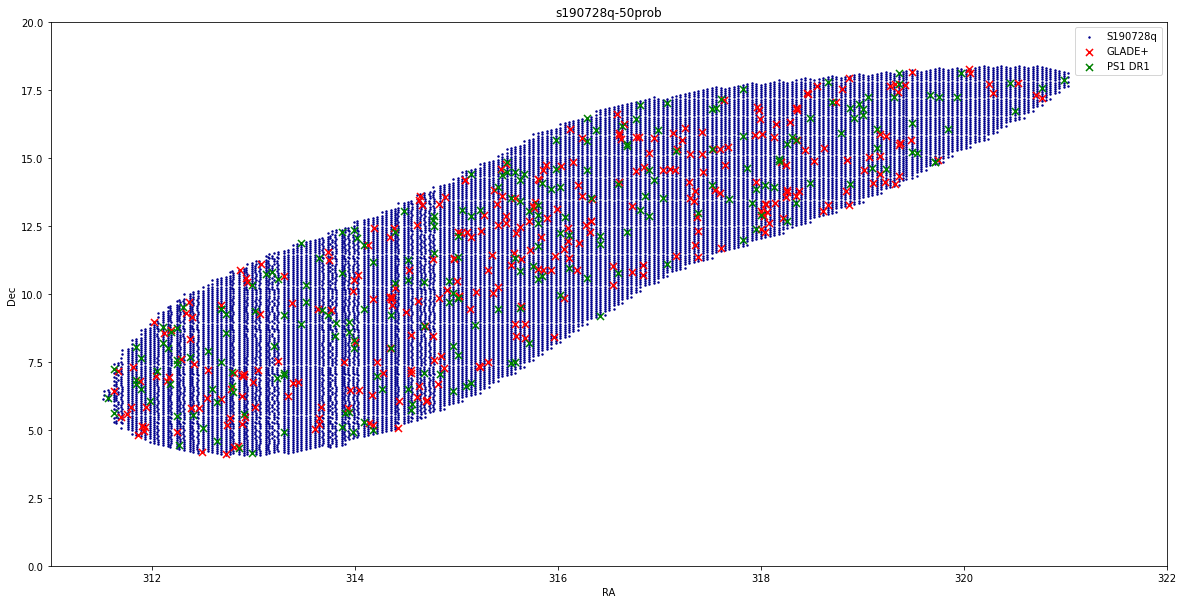

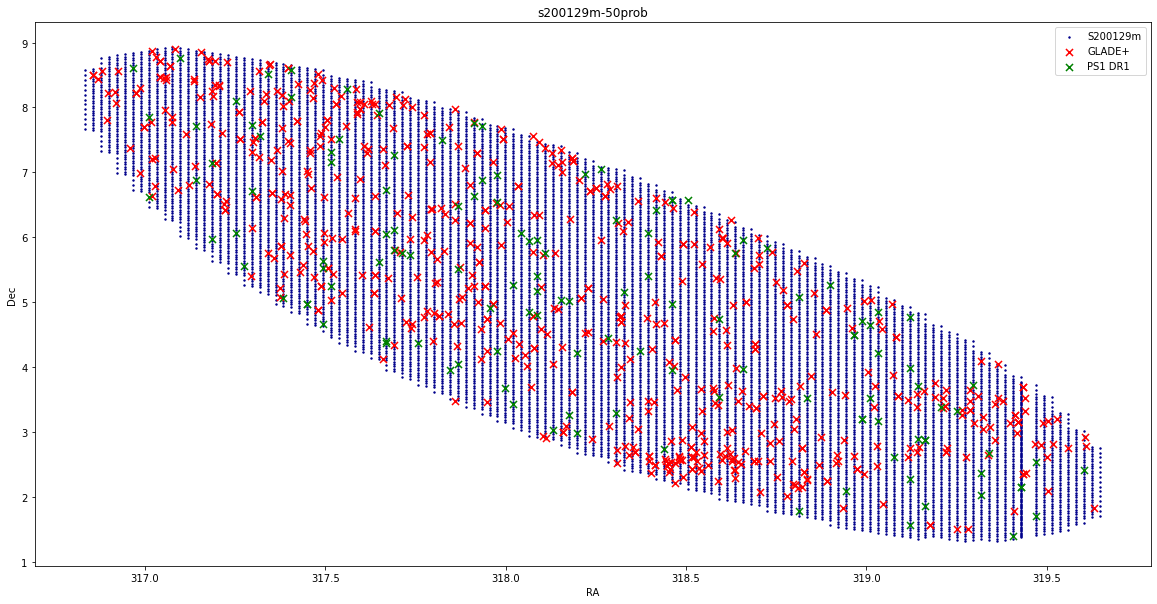

In [56]:
plt.figure(figsize=(20,10))
plt.scatter(e1['ra'], e1['dec'], label='S190728q', s=2, c='darkblue')
plt.scatter(e1_gp['RA'], e1_gp['Dec'], label='GLADE+', s=50, c='red', marker='x')
plt.scatter(e1_ps['ra'], e1_ps['dec'], label='PS1 DR1', s=50, c='green', marker='x')
plt.xlim(311, 322)
plt.ylim(0, 20)
plt.xlabel("RA")
plt.ylabel("Dec")
plt.title("s190728q-50prob")
plt.legend()

plt.figure(figsize=(20,10))
plt.scatter(e2['ra'], e2['dec'], label='S200129m', s=2, c='darkblue')
plt.scatter(e2_gp['RA'], e2_gp['Dec'], label='GLADE+', s=50, c='red', marker='x')
plt.scatter(e2_ps['ra'], e2_ps['dec'], label='PS1 DR1', s=50, c='green', marker='x')
plt.xlabel("RA")
plt.ylabel("Dec")
plt.title("s200129m-50prob")
plt.legend()